# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [3]:
# Drive parameters
noise_amp = 1e-2  # noise amplitude (mA/cm2)

# Stimulus parameters
start = 50 # start time (ms)
dur = 150  # duration (ms)
Pref = 1e6  # pressure amplitude (Pa)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep
Isppa_range_dense = sqrtspace(0, Imax, 30)  # dense range of intensities to sweep

# Simulation parameters
tstop = 350  # default simulation duration (ms)
nreps = 1  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'noise': [
        f'amplitude = {noise_amp:.3f} mA/cm2'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 20/12/2023 14:14:25: Input parameters:
   - noise:
       - amplitude = 0.010 mA/cm2
   - stimulus:
       - start = 50 ms
       - duration = 150 ms
       - P = 1.0 MPa <-> I = 30.91 W/cm2
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 350 ms
       - number of repetitions (for sweeps) = 1


## Network model

In [4]:
# Initialize 3-nodes model temperature-dependent components
nnodes = 3
model = NeuralNetwork(
    nnodes,
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=NeuralNetwork.gKT_default,  # S/cm2
    a=1e-4, 
    b=0.5,
    synweight=60e-6, # synaptic weight (S/cm2)
)

# Set stimulus start and duration
model.start = start
model.dur = dur

# Set simulation duration
model.tstop = tstop

 20/12/2023 14:14:25: NeuralNetwork(3): created 3 nodes
 20/12/2023 14:14:25: NeuralNetwork(3): connecting 100.0% (6/6) of candidate node pairs
 20/12/2023 14:14:25: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 20/12/2023 14:14:25: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 20/12/2023 14:14:25: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 20/12/2023 14:14:25: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 20/12/2023 14:14:25: NeuralNetwork(3): setting a = 0.0001 on all nodes
 20/12/2023 14:14:25: NeuralNetwork(3): setting b = 0.5 on all nodes
 20/12/2023 14:14:25: NeuralNetwork(3): initialized


## Simulations

### Test simulation

 20/12/2023 14:15:06: Spiking threshold: 26.80 W/cm2 <-> 0.52 uA/cm2
 20/12/2023 14:15:06: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 29.48 W/cm2 on 33.3% of nodes
 20/12/2023 14:15:06: NeuralNetwork(3): simulating for 350.00 ms
 20/12/2023 14:15:06: NeuralNetwork(3): plotting results
 20/12/2023 14:15:07: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 29.48 W/cm2 on 100.0% of nodes
 20/12/2023 14:15:07: NeuralNetwork(3): simulating for 350.00 ms
 20/12/2023 14:15:08: NeuralNetwork(3): plotting results


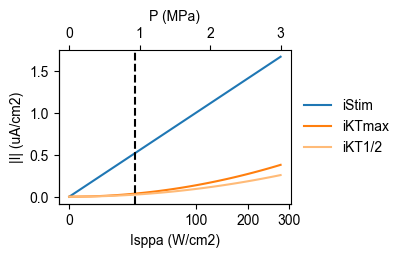

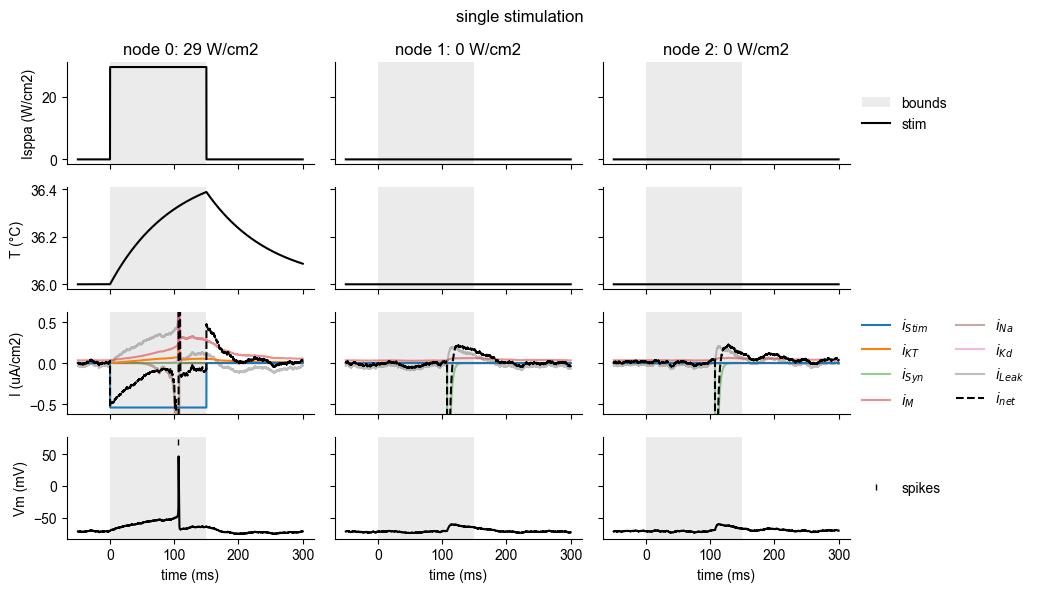

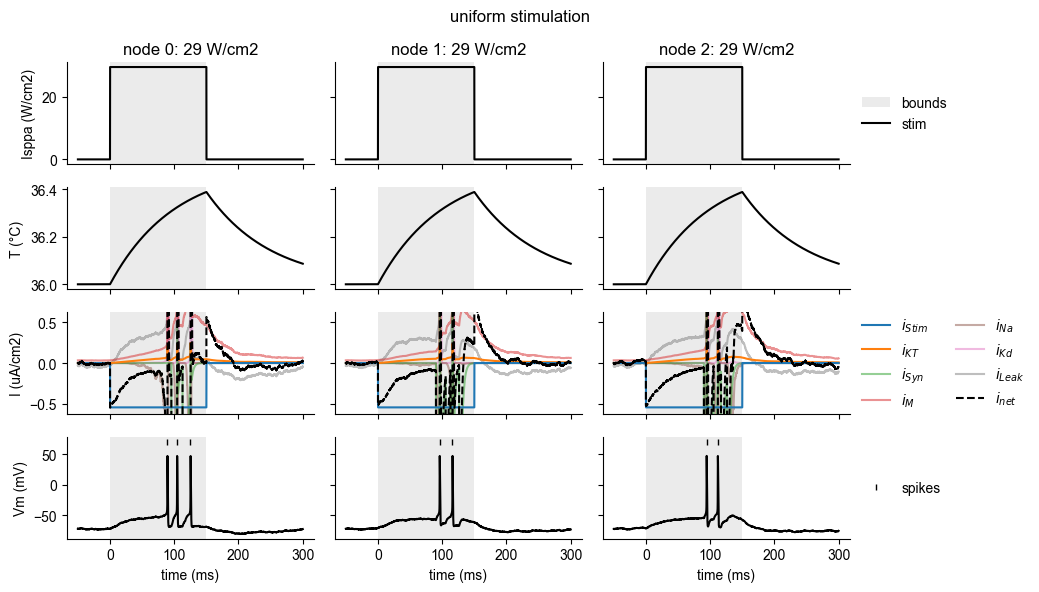

In [6]:
# Find spiking threshold and corresponding current amplitude
model.verbose = False
for Isppa in Isppa_range_dense:
    model.set_stim(Isppa)
    data = model.simulate()
    nspikes = model.compute_metric(data, 'nspikes')
    if nspikes.max() > 0:
        spike = True
        break
model.verbose = True
Ithr = Isppa
iStimthr = data['iStim'].abs().max()
logger.info(f'Spiking threshold: {Ithr:.2f} W/cm2 <-> {iStimthr * 1e3:.2f} uA/cm2')

# Plot EI imbalance over intensity range, and mark spiking threshold
fig = model.plot_EI_imbalance(Imax, xscale='sqrt')
ax = fig.axes[0]
ax.axvline(Isppa, color='k', linestyle='--')

# Set supra-threshold stimulus amplitude
Isppa = Ithr * 1.1

# Add stochastic noise
model.noise_amp = 2e-3  # noise_amp

# Plot simulation results at threshold 
for kind, xvec in model.get_stimdists().items():
    model.set_stim(Isppa * xvec)
    data = model.simulate()
    fig = model.plot_results(
        data, 
        exclude=[
            'conductances', 
        ], 
        clip_currents=True,
        add_net_current=True,
    )
    fig.suptitle(f'{kind} stimulation')
    # fig.savefig(f'figures/{kind}_stim_supra.pdf')

### Find noise level that gives a reasonable spontaneous activity level

 20/12/2023 14:15:21: NeuralNetwork(3): removing stimulus


100%|██████████| 15/15 [02:00<00:00,  8.02s/it]

 20/12/2023 14:17:22: noise amplitude corresponding to 4 Hz firing rate: 17.77 uA/cm2


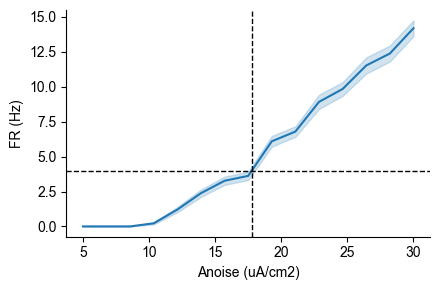

In [7]:
# Define range of noise amplitudes to sweep
noise_range = np.linspace(5, 30, 15) * 1e-3  # mA/cm2

# Remove stimulus
model.remove_stim()

# Simulate model for each noise amplitude
nspikes = []
model.verbose = False
for noise_amp in tqdm(noise_range):
    model.noise_amp = noise_amp
    data = model.simulate(nreps=30)
    nspikes.append(model.compute_metric(data, metric='nspikes'))
model.verbose = True

# Concatenate metric results, and average across nodes
nspikes = model.concatenate_outputs(noise_range * 1e3, nspikes, 'Anoise (uA/cm2)')

# Divide by simulation duration to get firing rate
fr = (nspikes / model.tstop * 1e3).rename('FR (Hz)')  # Hz 

# Interpolate noise amplitude corresponding to target average firing rate
target_fr = 4  # Hz
target_noise_amp = np.interp(
    target_fr, 
    fr.groupby('Anoise (uA/cm2)').mean(), 
    noise_range
)  # mA/cm2

# Plot firing rate as a function of noise amplitude
fg = sns.relplot(
    data=fr.reset_index(), 
    x='Anoise (uA/cm2)', 
    y='FR (Hz)', 
    kind='line', 
    errorbar='se',
    aspect=1.5,
    height=3,
)

# Plot target firing rate and corresponding noise amplitude
ax = fg.ax
ax.axhline(target_fr, ls='--', color='k', lw=1)
ax.axvline(target_noise_amp * 1e3, ls='--', color='k', lw=1)

# Round target noise amplitude to 2 decimals
target_noise_amp = np.round(target_noise_amp * 1e3, 2) * 1e-3
logger.info(f'noise amplitude corresponding to {target_fr} Hz firing rate: {target_noise_amp * 1e3:.2f} uA/cm2')

### Detailed Isppa dependencies and sub-threshold simulations for optimal parameter combinations

 20/12/2023 14:17:32: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 20/12/2023 14:17:32: NeuralNetwork(3): setting 150.00 ms stimulus with amplitude 29.48 W/cm2 on 100.0% of nodes
 20/12/2023 14:17:32: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


  0%|          | 0/30 [00:00<?, ?it/s]

 20/12/2023 14:17:32: NeuralNetwork(3): no noise current injection -> switching to variable dt


100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


 20/12/2023 14:17:40: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


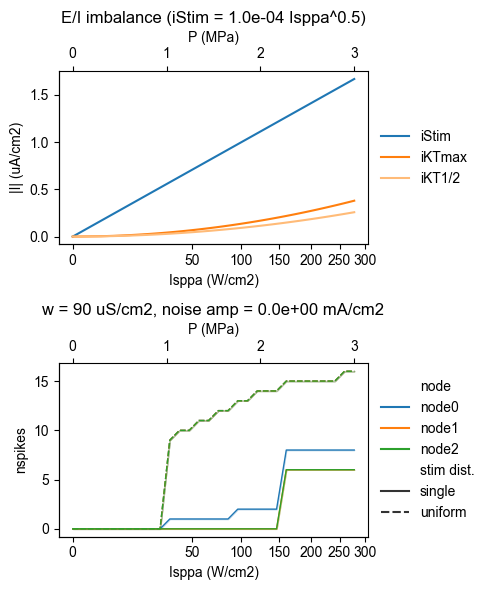

In [8]:
# Set stimulus sensitivity
model.set_mech_param(a=1e-4)

# Set synaptic weight
model.set_synaptic_weight(90e-6)

# Define range of noise amplitudes to sweep
# noise_range = np.array([target_noise_amp]) # np.linspace(5, 20, 7) * 1e-3  # mA/cm2
noise_range = np.array([0])

# Set stimulus
model.set_stim(Isppa, start=start, dur=dur)

# Initialize metric container
mdata = []

# For each noise amplitude
for noise_amp in noise_range:
    # Set noise amplitude
    model.noise_amp = noise_amp

    # Run comparative simulations across Isppa range and extract spike counts
    mdata.append(model.run_comparative_sweep(
        Isppa_range_dense, 
        'nspikes',
        nreps=10
    ))

# Concatenate metric dataframes
mdata = model.concatenate_outputs(noise_range, mdata, 'noise_amp')

# Create figure
fig, axes = plt.subplots(noise_range.size + 1, 1, figsize=(5, 3 * (noise_range.size + 1)))

# Pot E/I imbalance across Isppa range
model.plot_EI_imbalance(Imax, ax=axes[0], legend=True, xscale='sqrt')
axes[0].set_title(f'E/I imbalance (iStim = {model.a:.1e} Isppa^{model.b})', fontsize=12)

# Plot spike count across Isppa range for each noise amplitude
for ax, (noise_amp, gdata) in zip(axes[1:], mdata.groupby('noise_amp')):
    model.plot_sweep_results(
        gdata.droplevel('noise_amp'), 
        ax=ax, 
        legend=True, 
        marker=None, 
        xscale='sqrt',
        estimator='mean',
    )
    ax.set_title(f'w = {model.get_synaptic_weight() * 1e6:.0f} uS/cm2, noise amp = {noise_amp:.1e} mA/cm2', fontsize=12)

# Adjust figure layout
fig.tight_layout()

# Save figure
fig.savefig('nspikes_vs_pressure.pdf')

### Comparative detailed simulations for just sub-threshold conditions 

 12/12/2023 21:31:05: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 33.1 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 12/12/2023 21:31:05: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:05: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:06: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:06: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:06: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:07: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:07: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:07: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:08: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:08: NeuralNetwork(3): plotting results
 12/12/2023 21:31:09: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 16.2 W/cm2
    - node 1: 16.2 W/cm2
    - node 2: 16.2 W/cm2
 12/12/2023 21

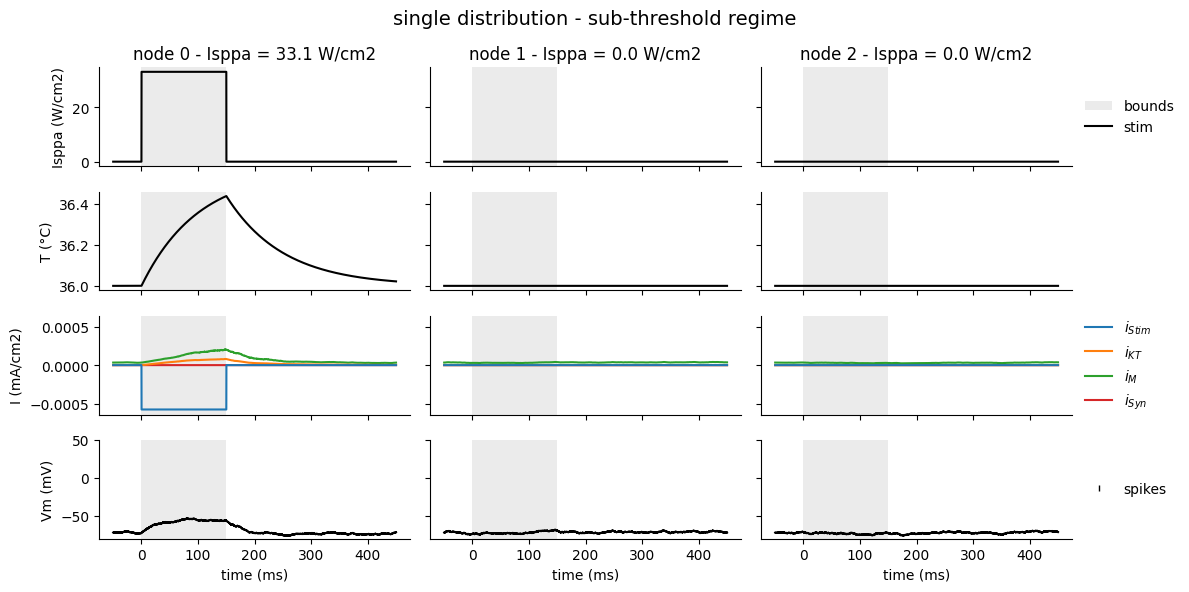

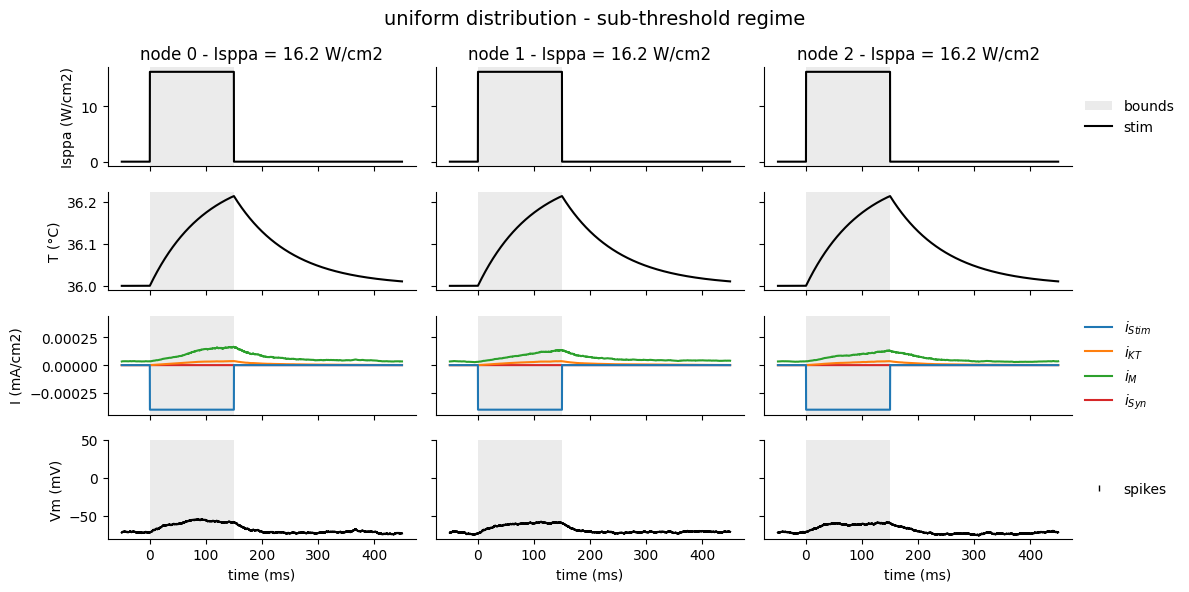

In [48]:
# Set preferred noise amplitude
model.noise_amp = 5e-3  # mA/cm2

# Find just sub-threshold Isppa values from preferred noise amplitude
nspikes_thr = 1
Ithrs = model.find_threshold(mdata, value=nspikes_thr).loc[model.noise_amp]

# For each stimulus distribution - Isppa pair
for kind, Ithr in Ithrs.items():
    # Set stimulus
    model.set_stim(Ithr * model.get_stimdist_vector(kind))
    # Simulate model until sub-threshold regime is reached
    data = model.simulate()
    nit = 1
    while nit < 100 and model.compute_metric(data, 'nspikes').max() >= nspikes_thr:
        data = model.simulate()
        nit += 1
    if model.compute_metric(data, 'nspikes').max() >= nspikes_thr:
        logger.warning(f'Failed to reach sub-threshold regime for {kind} distribution after {nit} iterations')
    # Plot results
    fig = model.plot_results(
        data, 
        exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iNoise'], 
        clip_currents=True)
    fig.suptitle(f'{kind} distribution - sub-threshold regime', fontsize=14)
    # Save figure
    fig.savefig(f'{kind}_subthreshold.pdf')

## Log completion

In [7]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 12/12/2023 18:01:36: notebook completed in 0:13:13.925222
